In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers, applications
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomZoom, RandomRotation, RandomFlip, Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pandas as pd
#import cv2
import logging
import warnings
import json
import time

In [2]:
#Suppress warnings from the logging module
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
#Tensorflow Version
print(tf.__version__)

2.10.0


In [3]:
#Check if any GPU devices are detected
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {len(gpus)}")
else:
    print("No GPU detected.")

GPUs detected: 1


In [27]:
#Global variables
IMAGE_DIMENSIONS = (64, 64)
BATCH_SIZE = 32
num_classes = 18 # Number of folders in dataset
AUTOTUNE = tf.data.AUTOTUNE

SEED = 385153

In [34]:
#Load Dataset
data_directory = 'hagdata/hagridset'
full_dataset = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    shuffle=True,
    seed=SEED,
    image_size=(IMAGE_DIMENSIONS),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Define ratios for splitting dataset
training_split = 0.7
validation_split = 0.1
testing_split = 0.2

# Calculate total dataset size
dataset_length = len(full_dataset)

# Calculate sizes of each subset
training_size = int(dataset_length * training_split)
validation_size = int(dataset_length * validation_split)
testing_size = dataset_length - (training_size + validation_size)

# Create dataset splits and shuffle
training_dataset = full_dataset.take(training_size).shuffle(training_size, seed=SEED)
validation_dataset = full_dataset.skip(training_size).take(validation_size).shuffle(validation_size, seed=SEED)
testing_dataset = full_dataset.skip(training_size + validation_size).shuffle(testing_size, seed=SEED)

# Cache and prefetch datasets
training_dataset = training_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
testing_dataset = testing_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Function to count samples in a dataset
def calculate_sample_count(ds):
    count = sum(1 for _ in ds.unbatch())
    return count

# Display the number of samples in each subset
print(f'Training set uses {calculate_sample_count(training_dataset)} samples')
print(f'Validation set uses {calculate_sample_count(validation_dataset)} samples')
print(f'Test set uses {calculate_sample_count(testing_dataset)} samples')

Found 125912 files belonging to 18 classes.
Training set uses 88128 samples
Validation set uses 12576 samples
Test set uses 25208 samples


In [26]:
#Get class names
class_names = full_dataset.class_names
class_names

['call',
 'dislike',
 'fist',
 'four',
 'like',
 'mute',
 'ok',
 'one',
 'palm',
 'peace',
 'peace_inverted',
 'rock',
 'stop',
 'stop_inverted',
 'three',
 'three2',
 'two_up',
 'two_up_inverted']

## Light CNN model

In [33]:
#Define the Light CNN Model from Scratch
def create_light_cnn_model():
    cnn_model = models.Sequential()
    cnn_model.add(tf.keras.Input(shape=(IMAGE_DIMENSIONS[0], IMAGE_DIMENSIONS[1], 3)))

    # Uncomment the next line if data augmentation is needed
    # model.add(data_augmentation_layers)

    cnn_model.add(layers.Rescaling(1.0 / 255))  # Normalise pixel values

    cnn_model.add(layers.Conv2D(32, 3, padding='same', activation='relu')) 
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(layers.MaxPooling2D())
    # cnn_model.add(layers.Dropout(0.1))

    cnn_model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    cnn_model.add(layers.MaxPooling2D())
    cnn_model.add(layers.Dropout(0.1))

    cnn_model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(layers.MaxPooling2D())
    cnn_model.add(layers.Dropout(0.1))

    cnn_model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(layers.MaxPooling2D())
    cnn_model.add(layers.Dropout(0.1))

    cnn_model.add(layers.Dense(256, activation='relu'))
    cnn_model.add(layers.Dropout(0.3))

    cnn_model.add(layers.Flatten())

    cnn_model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile your model with an initial learning rate
    cnn_model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
        )

    return cnn_model

#Instantiate and summarise the lighter model
light_cnn = create_light_cnn_model()
light_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)      

In [34]:
def train_light_cnn_model(cnn_model, training_data, validation_data, epochs=10):
    # Define a learning rate schedule
    def lr_time_based_decay(epoch, lr):
        return lr * 1 / (1 + 0.01 * epoch)
    
    # Setup callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay, verbose=1)
    ]
    
    # Train the model
    training_history = cnn_model.fit(
        training_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=callbacks
    )
    
    return training_history

# Use the defined method to train the light CNN model
light_history = train_light_cnn_model(light_cnn, training_dataset, validation_dataset)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10


2754/2754 [==============================] - 51s 18ms/step - loss: 1.7653 - accuracy: 0.4381 - val_loss: 1.1265 - val_accuracy: 0.6438 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009900990569281696.
Epoch 2/10
2754/2754 [==============================] - 48s 17ms/step - loss: 0.8871 - accuracy: 0.7151 - val_loss: 0.7104 - val_accuracy: 0.7797 - lr: 9.9010e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009706853341092082.
Epoch 3/10
2754/2754 [==============================] - 49s 18ms/step - loss: 0.6647 - accuracy: 0.7880 - val_loss: 0.6219 - val_accuracy: 0.8056 - lr: 9.7069e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009424129424128428.
Epoch 4/10
2754/2754 [==============================] - 50s 18ms/step - loss: 0.5487 - accuracy: 0.8254 - val_loss: 0.4727 - val_accuracy: 0.8514 - lr: 9.4241e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009061662869778676.
Epoch 5/10
2754/2754 [=====================

788/788 [==============================] - 5s 6ms/step
Inference Time: 6.278865337371826 seconds


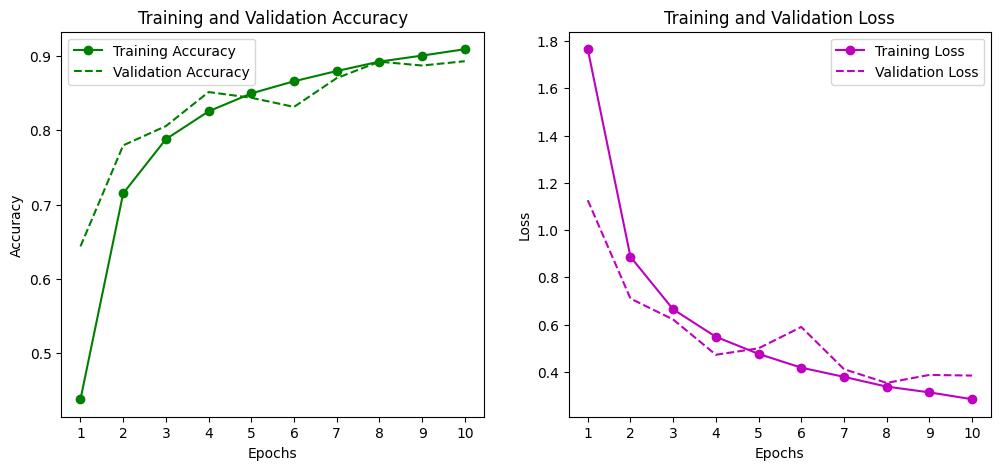

In [39]:
# Measure inference time
start_time = time.time()
predictions = light_cnn.predict(testing_dataset)  # Make sure testing_dataset is prepared correctly
inference_time = time.time() - start_time
print(f"Inference Time: {inference_time} seconds")

# Access the training history dictionary from the consolidated function
acc = light_history.history['accuracy']
val_acc = light_history.history['val_accuracy']
loss = light_history.history['loss']
val_loss = light_history.history['val_loss']

# Calculate the number of epochs based on the length of any metric list
epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy with new colors
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'go-', label='Training Accuracy')  # Changed to green with line
plt.plot(epochs, val_acc, 'g--', label='Validation Accuracy')  # Changed to green dashed line
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(acc) + 1))  # Set x-ticks to show each epoch
plt.legend()

# Plotting training and validation loss with new colors
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'mo-', label='Training Loss')  # Changed to magenta with line
plt.plot(epochs, val_loss, 'm--', label='Validation Loss')  # Changed to magenta dashed line
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(acc) + 1))  # Set x-ticks to show each epoch
plt.legend()

plt.show()


## Greyscale


In [14]:
# Load Dataset in grayscale
dataset_path = 'hagdata/hagridset'
greyscale_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    seed=SEED,
    image_size=IMAGE_DIMENSIONS,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',  # Load images as grayscale
    label_mode='categorical'
)

Found 125912 files belonging to 18 classes.


In [15]:
print("Found {} files belonging to {} classes.".format(len(greyscale_dataset.file_paths), len(greyscale_dataset.class_names)))
print("Dataset element spec:", greyscale_dataset.element_spec)

Found 125912 files belonging to 18 classes.
Dataset element spec: (TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None))


In [18]:

# Define ratios for splitting dataset
training_split = 0.7
validation_split = 0.1
testing_split = 0.2

# Calculate total dataset size
dataset_length = len(greyscale_dataset)

# Calculate sizes of each subset
training_size = int(dataset_length * training_split)
validation_size = int(dataset_length * validation_split)
testing_size = dataset_length - (training_size + validation_size)

# Create dataset splits and shuffle
training_dataset = greyscale_dataset.take(training_size).shuffle(training_size, seed=SEED)
validation_dataset = greyscale_dataset.skip(training_size).take(validation_size).shuffle(validation_size, seed=SEED)
testing_dataset = greyscale_dataset.skip(training_size + validation_size).shuffle(testing_size, seed=SEED)

# Cache and prefetch datasets
training_dataset = training_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
testing_dataset = testing_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Function to count samples in a dataset
def calculate_sample_count(ds):
    count = sum(1 for _ in ds.unbatch())
    return count

# Display the number of samples in each subset
print(f'Training set uses {calculate_sample_count(training_dataset)} samples')
print(f'Validation set uses {calculate_sample_count(validation_dataset)} samples')
print(f'Test set uses {calculate_sample_count(testing_dataset)} samples')

Training set uses 88128 samples
Validation set uses 12576 samples
Test set uses 25208 samples


In [19]:
def create_greyscale_cnn_model():
    grey_model = models.Sequential()
    # Adjust input layer to accept greyscale images (64, 64, 1)
    grey_model.add(tf.keras.Input(shape=(IMAGE_DIMENSIONS[0], IMAGE_DIMENSIONS[1], 1)))  

    grey_model.add(layers.Rescaling(1.0 / 255))  # Normalise pixel values

    grey_model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
    grey_model.add(layers.BatchNormalization())
    grey_model.add(layers.MaxPooling2D())

    grey_model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    grey_model.add(layers.MaxPooling2D())
    grey_model.add(layers.Dropout(0.1))

    grey_model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
    grey_model.add(layers.BatchNormalization())
    grey_model.add(layers.MaxPooling2D())
    grey_model.add(layers.Dropout(0.1))

    grey_model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
    grey_model.add(layers.BatchNormalization())
    grey_model.add(layers.MaxPooling2D())
    grey_model.add(layers.Dropout(0.1))

    grey_model.add(layers.Dense(256, activation='relu'))
    grey_model.add(layers.Dropout(0.3))

    grey_model.add(layers.Flatten())

    grey_model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model with an initial learning rate
    grey_model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return grey_model


In [20]:
# Instantiate the greyscale model
greyscale_cnn = create_greyscale_cnn_model()
greyscale_cnn.summary()

# Training function remains the same
def train_greyscale_cnn_model(cnn_model, train_data, validate_data, epochs=10):
    def lr_decay(epoch, lr):
        return lr * 1 / (1 + 0.01 * epoch)

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=1)
    ]
    
    # Train the model directly using the dataset
    training_history = cnn_model.fit(
        train_data,
        epochs=epochs,
        validation_data=validate_data,
        callbacks=callbacks
    )
    
    return training_history




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0

In [21]:
for images, labels in greyscale_dataset.take(1):
    print("Batch shape:", images.shape)  # Should be (batch_size, 64, 64, 1)
    print("Labels shape:", labels.shape)

Batch shape: (32, 64, 64, 1)
Labels shape: (32, 18)


In [22]:
# Train the greyscale CNN model
greyscale_history = train_greyscale_cnn_model(greyscale_cnn, training_dataset, validation_dataset)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
2754/2754 [==============================] - 68s 20ms/step - loss: 1.8604 - accuracy: 0.4088 - val_loss: 1.3495 - val_accuracy: 0.5737 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009900990569281696.
Epoch 2/10
2754/2754 [==============================] - 55s 20ms/step - loss: 1.1211 - accuracy: 0.6392 - val_loss: 1.0796 - val_accuracy: 0.6618 - lr: 9.9010e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009706853341092082.
Epoch 3/10
2754/2754 [==============================] - 58s 21ms/step - loss: 0.8693 - accuracy: 0.7221 - val_loss: 0.9921 - val_accuracy: 0.6908 - lr: 9.7069e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009424129424128428.
Epoch 4/10
2754/2754 [==============================] - 56s 20ms/step - loss: 0.7337 - accuracy: 0.7638 - val_loss: 0.7510 - val_accuracy: 0.7634 - lr: 9.4241e-04

Epoch 5: LearningRateScheduler 

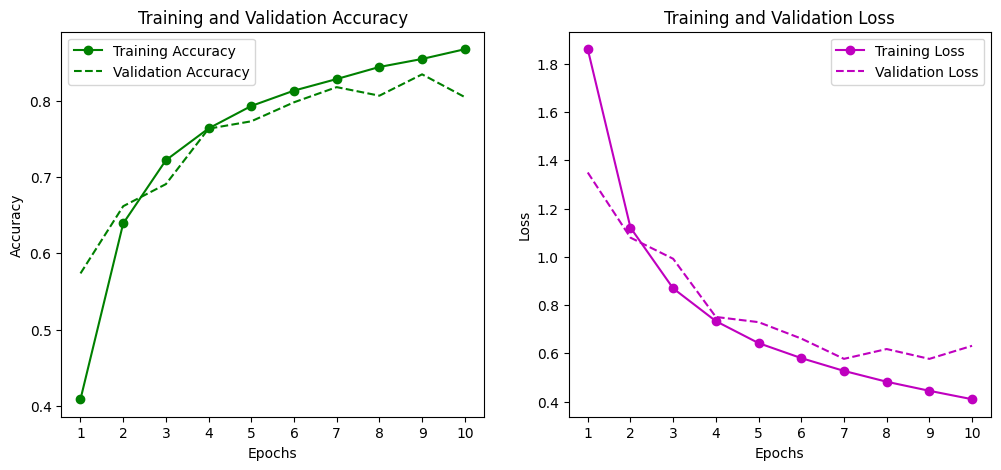

In [24]:
# Access the training history dictionary from the consolidated function
acc = greyscale_history.history['accuracy']
val_acc = greyscale_history.history['val_accuracy']
loss = greyscale_history.history['loss']
val_loss = greyscale_history.history['val_loss']

# Calculate the number of epochs based on the length of any metric list
epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy with new colors
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'go-', label='Training Accuracy')  # Changed to green with line
plt.plot(epochs, val_acc, 'g--', label='Validation Accuracy')  # Changed to green dashed line
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(acc) + 1))  # Set x-ticks to show each epoch
plt.legend()

# Plotting training and validation loss with new colors
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'mo-', label='Training Loss')  # Changed to magenta with line
plt.plot(epochs, val_loss, 'm--', label='Validation Loss')  # Changed to magenta dashed line
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(acc) + 1))  # Set x-ticks to show each epoch
plt.legend()

plt.show()

## DATA AUG

In [5]:
# Data Augmentation
data_augmentation_layers = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
])

In [6]:
#Load Dataset
data_directory = 'hagdata/hagridset'
full_dataset = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    shuffle=True,
    seed=SEED,
    image_size=(IMAGE_DIMENSIONS),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Define ratios for splitting dataset
training_split = 0.7
validation_split = 0.1
testing_split = 0.2

# Calculate total dataset size
dataset_length = len(full_dataset)

# Calculate sizes of each subset
training_size = int(dataset_length * training_split)
validation_size = int(dataset_length * validation_split)
testing_size = dataset_length - (training_size + validation_size)

# Create dataset splits and shuffle
training_dataset = full_dataset.take(training_size).shuffle(training_size, seed=SEED)
validation_dataset = full_dataset.skip(training_size).take(validation_size).shuffle(validation_size, seed=SEED)
testing_dataset = full_dataset.skip(training_size + validation_size).shuffle(testing_size, seed=SEED)

# Cache and prefetch datasets
training_dataset = training_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
testing_dataset = testing_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Function to count samples in a dataset
def calculate_sample_count(ds):
    count = sum(1 for _ in ds.unbatch())
    return count

# Display the number of samples in each subset
print(f'Training set uses {calculate_sample_count(training_dataset)} samples')
print(f'Validation set uses {calculate_sample_count(validation_dataset)} samples')
print(f'Test set uses {calculate_sample_count(testing_dataset)} samples')

Found 125912 files belonging to 18 classes.
Training set uses 88128 samples
Validation set uses 12576 samples
Test set uses 25208 samples


In [7]:
#Define the Light CNN Model from Scratch
def create_aug_cnn_model():
    aug_model = models.Sequential()
    aug_model.add(tf.keras.Input(shape=(IMAGE_DIMENSIONS[0], IMAGE_DIMENSIONS[1], 3)))
    aug_model.add(data_augmentation_layers)
    aug_model.add(layers.Rescaling(1.0 / 255))  # Normalise pixel values

    aug_model.add(layers.Conv2D(32, 3, padding='same', activation='relu')) 
    aug_model.add(layers.BatchNormalization())
    aug_model.add(layers.MaxPooling2D())
    aug_model.add(layers.Dropout(0.1))

    aug_model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    aug_model.add(layers.MaxPooling2D())
    aug_model.add(layers.Dropout(0.1))

    aug_model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
    aug_model.add(layers.BatchNormalization())
    aug_model.add(layers.MaxPooling2D())
    aug_model.add(layers.Dropout(0.1))

    aug_model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
    aug_model.add(layers.BatchNormalization())
    aug_model.add(layers.MaxPooling2D())
    aug_model.add(layers.Dropout(0.1))

    aug_model.add(layers.Dense(256, activation='relu'))
    aug_model.add(layers.Dropout(0.3))

    aug_model.add(layers.Flatten())

    aug_model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile your model with an initial learning rate
    aug_model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return aug_model

#Instantiate and summarise the lighter model
aug_cnn = create_aug_cnn_model()
aug_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)       

In [8]:
def train_aug_cnn_model(aug_model, training_data, validation_data, epochs=10):
    # Define a learning rate schedule
    def lr_time_based_decay(epoch, lr):
        return lr * 1 / (1 + 0.01 * epoch)
    
    # Setup callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay, verbose=1)
    ]
    
    # Train the model
    training_history = aug_model.fit(
        training_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=callbacks
    )
    
    return training_history

# Use the defined method to train the light CNN model
aug_history = train_aug_cnn_model(aug_cnn, training_dataset, validation_dataset)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
2754/2754 [==============================] - 541s 191ms/step - loss: 1.9176 - accuracy: 0.3914 - val_loss: 1.2456 - val_accuracy: 0.5902 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009900990569281696.
Epoch 2/10
2754/2754 [==============================] - 536s 194ms/step - loss: 1.0826 - accuracy: 0.6520 - val_loss: 0.8474 - val_accuracy: 0.7331 - lr: 9.9010e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009706853341092082.
Epoch 3/10
2754/2754 [==============================] - 523s 190ms/step - loss: 0.8641 - accuracy: 0.7235 - val_loss: 0.7384 - val_accuracy: 0.7739 - lr: 9.7069e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009424129424128428.
Epoch 4/10
2754/2754 [==============================] - 534s 194ms/step - loss: 0.7468 - accuracy: 0.7621 - val_loss: 0.5864 - val_accuracy: 0.8143 - lr: 9.4241e-04

Epoch 5: LearningRateSc

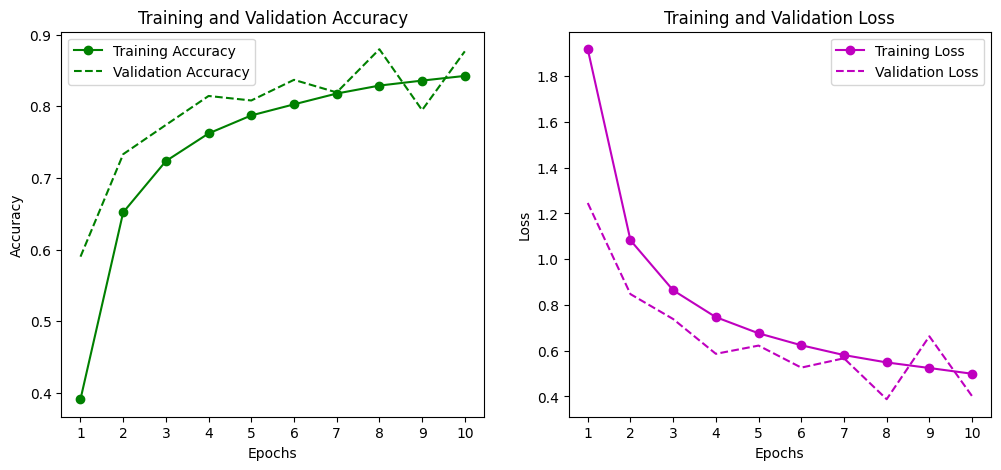

In [9]:
# Access the training history dictionary from the consolidated function
acc = aug_history.history['accuracy']
val_acc = aug_history.history['val_accuracy']
loss = aug_history.history['loss']
val_loss = aug_history.history['val_loss']

# Calculate the number of epochs based on the length of any metric list
epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy with new colors
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'go-', label='Training Accuracy')  # Changed to green with line
plt.plot(epochs, val_acc, 'g--', label='Validation Accuracy')  # Changed to green dashed line
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(acc) + 1))  # Set x-ticks to show each epoch
plt.legend()

# Plotting training and validation loss with new colors
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'mo-', label='Training Loss')  # Changed to magenta with line
plt.plot(epochs, val_loss, 'm--', label='Validation Loss')  # Changed to magenta dashed line
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(acc) + 1))  # Set x-ticks to show each epoch
plt.legend()

plt.show()

## VGG-16

In [5]:
data_directory = 'hagdata/hagridset'
full_dataset =  tf.keras.utils.image_dataset_from_directory(
    data_directory,
    shuffle=True,
    seed=SEED,
    image_size=IMAGE_DIMENSIONS,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Define ratios for splitting dataset
training_split = 0.7
validation_split = 0.1
testing_split = 0.2

# Calculate sizes of each subset
dataset_length = len(full_dataset)
training_size = int(dataset_length * training_split)
validation_size = int(dataset_length * validation_split)
testing_size = dataset_length - (training_size + validation_size)

# Create dataset splits and shuffle
train_dataset = full_dataset.take(training_size).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = full_dataset.skip(training_size).take(validation_size).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = full_dataset.skip(training_size + validation_size).take(testing_size).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

Found 125912 files belonging to 18 classes.


In [6]:
# Define data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomZoom(0.1),
    layers.RandomRotation(0.1),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.Rescaling(1./255)
])

In [7]:
def create_vgg16_model(input_shape, num_classes):
    # Load VGG16 without the top layer (fully connected layers)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers in the base model to prevent them from being updated during training
    for layer in base_model.layers:
        layer.trainable = False

    # Add new classifier layers
    x = layers.GlobalAveragePooling2D()(base_model.output)  # Convert features to vectors
    x = layers.Dense(1024, activation='relu')(x)  # A dense layer with relu activation
    x = layers.Dropout(0.5)(x)  # Dropout for regularization
    predictions = layers.Dense(num_classes, activation='softmax')(x)  # Final softmax layer for classification

    # Combine the base model and the new layers into a single model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [11]:
input_shape = (64, 64, 3)  # Assuming RGB images
vgg16_model = create_vgg16_model(input_shape, num_classes)
vgg16_model.summary()  # Displays the architecture of the model


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [12]:
# Define the learning rate scheduler
def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = vgg16_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1  # Set verbose to 1 for detailed output
)



Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/10


2754/2754 [==============================] - 65s 24ms/step - loss: 2.4610 - accuracy: 0.2671 - val_loss: 2.2010 - val_accuracy: 0.3185 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/10
2754/2754 [==============================] - 66s 24ms/step - loss: 2.3259 - accuracy: 0.3056 - val_loss: 2.1672 - val_accuracy: 0.3357 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/10
2754/2754 [==============================] - 66s 24ms/step - loss: 2.2586 - accuracy: 0.3241 - val_loss: 2.1504 - val_accuracy: 0.3420 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/10
2754/2754 [==============================] - 66s 24ms/step - loss: 2.2214 - accuracy: 0.3383 - val_loss: 2.1481 - val_accuracy: 0.3542 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 5/10
2754/2754 [=================

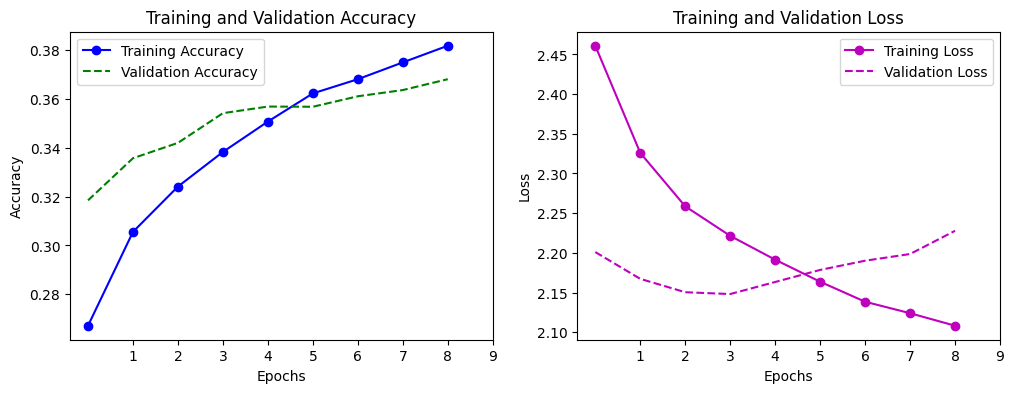

In [15]:
# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g--', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(acc) + 1))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'mo-', label='Training Loss')
plt.plot(epochs, val_loss, 'm--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(acc) + 1))
plt.legend()

plt.show()

In [4]:
IMAGE_DIMENSIONS = (128, 128)  # Increase image size
BATCH_SIZE = 32
NUM_CLASSES = 18  # Number of classes in your dataset
AUTOTUNE = tf.data.AUTOTUNE
SEED = 385153


In [5]:
data_directory = 'hagdata/hagridset'

full_dataset = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    shuffle=True,
    seed=SEED,
    image_size=IMAGE_DIMENSIONS,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# Define ratios for splitting dataset
training_split = 0.7
validation_split = 0.1
testing_split = 0.2

# Calculate sizes of each subset
dataset_length = len(full_dataset)
training_size = int(dataset_length * training_split)
validation_size = int(dataset_length * validation_split)
testing_size = dataset_length - (training_size + validation_size)

# Create dataset splits and shuffle
train_dataset = full_dataset.take(training_size).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = full_dataset.skip(training_size).take(validation_size).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = full_dataset.skip(training_size + validation_size).take(testing_size).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)


Found 125912 files belonging to 18 classes.


In [6]:
data_augmentation = tf.keras.Sequential([
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomContrast(0.2),
    layers.Rescaling(1./255)
])


In [7]:
def create_second_vgg16_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Unfreeze the last 4 layers
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile with Adam optimizer and a lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [9]:
input_shape = (128, 128, 3)  # Assuming RGB images
vgg16_model = create_second_vgg16_model(input_shape, NUM_CLASSES)
vgg16_model.summary()  # Displays the architecture of the model


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [10]:
def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)


In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = vgg16_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  
    callbacks=[early_stopping, lr_scheduler],
    verbose=1  # Set verbose to 1 for detailed output
)



Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/10
2754/2754 [==============================] - 494s 168ms/step - loss: 1.4651 - accuracy: 0.5195 - val_loss: 0.3777 - val_accuracy: 0.8772 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/10
2754/2754 [==============================] - 573s 208ms/step - loss: 0.3019 - accuracy: 0.9040 - val_loss: 0.3317 - val_accuracy: 0.9008 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/10
2754/2754 [==============================] - 554s 201ms/step - loss: 0.1824 - accuracy: 0.9417 - val_loss: 0.2712 - val_accuracy: 0.9196 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/10
2754/2754 [==============================] - 606s 220ms/step - loss: 0.1220 - accuracy: 0.9599 - val_loss: 0.2927 - val_accuracy: 0.9200 - lr: 1.0000e-04

Epoch 5: LearningRa

In [13]:
test_loss, test_accuracy = vgg16_model.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy:.2f}')


788/788 [==============================] - 45s 57ms/step - loss: 0.2747 - accuracy: 0.9169
Test accuracy: 0.92


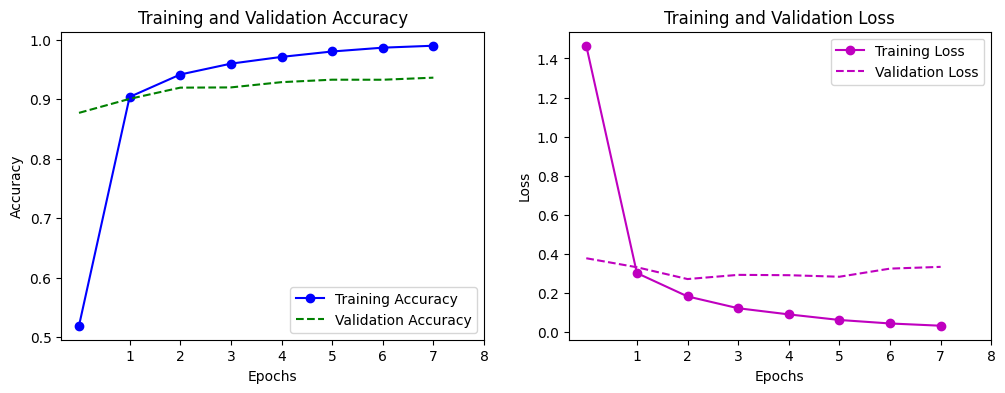

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g--', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(acc) + 1))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'mo-', label='Training Loss')
plt.plot(epochs, val_loss, 'm--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(acc) + 1))
plt.legend()

plt.show()


1/1 [==============================] - 0s 31ms/step


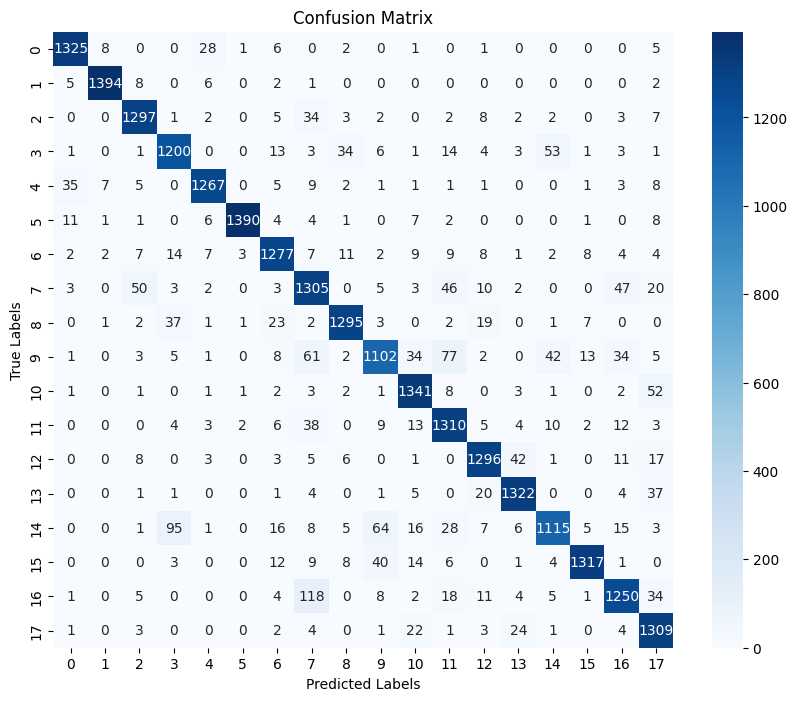

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true labels and predictions
true_labels = []
pred_labels = []

for images, labels in test_dataset:
    preds = vgg16_model.predict(images)
    true_labels.extend(tf.argmax(labels, axis=1).numpy())
    pred_labels.extend(tf.argmax(preds, axis=1).numpy())

# Generate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
